In [1]:
import pandas as pd
import numpy as np
import json
import swifter
import nltk
import string
import re
import ast
import emoji_data_python
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import codecs
from matplotlib import pyplot as plt
import seaborn as sns

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_comments = pd.read_csv("./rb_data/all_comments.csv", parse_dates=['createdAt', 'updatedAt'], header=0)
df_users = pd.read_csv("./rb_data/all_users.csv", header=0)
df_posts = pd.read_csv("./rb_data/all_posts.csv", parse_dates=['createdAt', 'updatedAt'], header=0)
df_report_user = pd.read_csv("./rb_data/all_report_user.csv", parse_dates=['createdAt', 'updatedAt'], header=0)

In [5]:
df_socks_assigns = pd.read_csv('./assigns/sockpuppet_assigned.csv', header=0)

In [12]:
df_posts = df_posts[df_posts['AuthorId'].notna()]  # filter our missing data

In [6]:
df_socks_assigns['strategy'].value_counts()

OVERT           81
UNRESTRICTED    73
COVERT          56
Name: strategy, dtype: int64

In [8]:
# store the roles in three lists
sockpuppets, participants, observers = [], [], []
for idx, row in df_users.iterrows():
    if 'dartpost' in row['email']:
        participants.append(row['id'])
    if 'observer' in row['email']:
        observers.append(row['id'])
    if 'sockpuppet' in row['email']:
        sockpuppets.append(row['id'])

In [13]:
# set a new column in posts with actual roles
df_posts['AuthorId'] = [int(id) for id in df_posts['AuthorId'].tolist()]
def return_role(text):
    if text in participants:
        return 'participant'
    if text in observers:
        return 'observer'
    else:
        return 'sockpuppet'

In [14]:
df_posts['role'] = df_posts['AuthorId'].swifter.allow_dask_on_strings().apply(return_role)

In [16]:
df_posts.head()

,id,text,picture_url,parent_id,root_id,is_marked,tags,createdAt,updatedAt,AuthorId,is_trending,role
0,93,I think that we should move away from nuclear ...,NaN,NaN,NaN,f,"{nuclear,energy,enviroment}",2020-09-03 01:59:10.051000+00:00,2020-09-04 13:08:51.133000+00:00,2580,f,participant
1,94,"Given the security put in place since 911, it ...",NaN,NaN,NaN,f,{TerroristAttack},2020-09-03 02:28:29.002000+00:00,2020-09-04 13:08:51.133000+00:00,2593,f,participant
2,95,NaN,NaN,NaN,NaN,t,"{""""}",2020-09-03 02:31:10.028000+00:00,2020-09-03 02:34:29.992000+00:00,2611,f,participant
3,96,It is crucial that the United States plays a r...,NaN,NaN,NaN,f,{Worldaffairs},2020-09-03 02:34:07.312000+00:00,2020-09-04 13:08:51.133000+00:00,2593,f,participant
4,97,Strongly disapprove of a two percent annual ta...,NaN,NaN,NaN,f,{WealthTax},2020-09-03 02:36:27.825000+00:00,2020-09-04 13:08:51.133000+00:00,2593,f,participant


In [17]:
# pick the columns of our interests
sel_cols = ['text', 'tags', 'createdAt', 'updatedAt', 'AuthorId', 'role']
df_posts = df_posts[sel_cols]
df_posts.head()

,text,tags,createdAt,updatedAt,AuthorId,role
0,I think that we should move away from nuclear ...,"{nuclear,energy,enviroment}",2020-09-03 01:59:10.051000+00:00,2020-09-04 13:08:51.133000+00:00,2580,participant
1,"Given the security put in place since 911, it ...",{TerroristAttack},2020-09-03 02:28:29.002000+00:00,2020-09-04 13:08:51.133000+00:00,2593,participant
2,NaN,"{""""}",2020-09-03 02:31:10.028000+00:00,2020-09-03 02:34:29.992000+00:00,2611,participant
3,It is crucial that the United States plays a r...,{Worldaffairs},2020-09-03 02:34:07.312000+00:00,2020-09-04 13:08:51.133000+00:00,2593,participant
4,Strongly disapprove of a two percent annual ta...,{WealthTax},2020-09-03 02:36:27.825000+00:00,2020-09-04 13:08:51.133000+00:00,2593,participant


In [19]:
# double check the datetime
df_posts.dtypes

text                      object
tags                      object
createdAt    datetime64[ns, UTC]
updatedAt    datetime64[ns, UTC]
AuthorId                   int64
role                      object
dtype: object

In [20]:
df_posts = df_posts.set_index('createdAt')
df_posts.head()

,text,tags,updatedAt,AuthorId,role
createdAt,,,,,
2020-09-03 01:59:10.051000+00:00,I think that we should move away from nuclear ...,"{nuclear,energy,enviroment}",2020-09-04 13:08:51.133000+00:00,2580,participant
2020-09-03 02:28:29.002000+00:00,"Given the security put in place since 911, it ...",{TerroristAttack},2020-09-04 13:08:51.133000+00:00,2593,participant
2020-09-03 02:31:10.028000+00:00,NaN,"{""""}",2020-09-03 02:34:29.992000+00:00,2611,participant
2020-09-03 02:34:07.312000+00:00,It is crucial that the United States plays a r...,{Worldaffairs},2020-09-04 13:08:51.133000+00:00,2593,participant
2020-09-03 02:36:27.825000+00:00,Strongly disapprove of a two percent annual ta...,{WealthTax},2020-09-04 13:08:51.133000+00:00,2593,participant


In [54]:
for idx, row in df_posts.iterrows():
    if row['role'] == 'participant':
        df_posts.loc[idx, 'participant'] = 1
        df_posts.loc[idx, 'sockpuppet'] = 0
    else:
        df_posts.loc[idx, 'sockpuppet'] = 1
        df_posts.loc[idx, 'participant'] = 0

In [55]:
df_posts.head()

,text,tags,updatedAt,AuthorId,role,participant,sockpuppet
createdAt,,,,,,,
2020-09-03 01:59:10.051000+00:00,I think that we should move away from nuclear ...,"{nuclear,energy,enviroment}",2020-09-04 13:08:51.133000+00:00,2580,participant,1.0,0.0
2020-09-03 02:28:29.002000+00:00,"Given the security put in place since 911, it ...",{TerroristAttack},2020-09-04 13:08:51.133000+00:00,2593,participant,1.0,0.0
2020-09-03 02:31:10.028000+00:00,NaN,"{""""}",2020-09-03 02:34:29.992000+00:00,2611,participant,1.0,0.0
2020-09-03 02:34:07.312000+00:00,It is crucial that the United States plays a r...,{Worldaffairs},2020-09-04 13:08:51.133000+00:00,2593,participant,1.0,0.0
2020-09-03 02:36:27.825000+00:00,Strongly disapprove of a two percent annual ta...,{WealthTax},2020-09-04 13:08:51.133000+00:00,2593,participant,1.0,0.0


In [56]:
df_posts_hour = pd.DataFrame(df_posts.index.to_period('h'))
df_posts_hour = df_posts_hour.reset_index()
del df_posts_hour['index']
# hourly = hourly.rename({'createdAt': 'hour'})
df_posts_hour['sockpuppet'] = df_posts['sockpuppet'].to_list()
df_posts_hour['participant'] = df_posts['participant'].to_list()
df_posts_hour.head()

/home/ruibo/anaconda3/envs/tf_gpu_env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,createdAt,sockpuppet,participant
0,2020-09-03 01:00,0.0,1.0
1,2020-09-03 02:00,0.0,1.0
2,2020-09-03 02:00,0.0,1.0
3,2020-09-03 02:00,0.0,1.0
4,2020-09-03 02:00,0.0,1.0


In [38]:
hourly = hourly.rename({'createdAt': 'hour'})

In [59]:
hourly = df_posts_hour.groupby(['createdAt']).sum()

<AxesSubplot:xlabel='createdAt'>

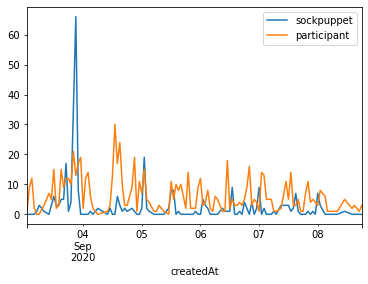

In [64]:
hourly.plot()